# Introduction

This notebook documents data acquisition and processing for ***Washington-Allen et al. 2019 (in prep)***. Processed in **Python (3.6) environment** using common scientific data processing libraries. 

**Questions:** [jjmcnelis@outlook.com](mailto:jjmcnelis@outlook.com)

## Environment

**Windows 10 running Ubuntu 16.04 via Windows Subsystem for Linux** 

All consumer-grade (but high-end) hardware: 
* i7 8700K 6-cores (12t), 
* 32g memory, 
* Samsung EVO PCIe NVM-e 500G SSD. 

**Python 3.6 --- required packages**

* `xarray` pandas-like toolkit for analytics on n-dimensional arrays http://xarray.pydata.org/en/stable/index.html 
* `dask` flexible library for parallel computing https://docs.dask.org/en/latest/ 
* `gdal,ogr,osr` only used to make a grid from the drylands mask. Use GDAL command-line tools if gdal for python isnt available. 

In [1]:
import os,json,math                        # general env use and reading json configs
import xarray,pandas,numpy                 # <-- these do 99.9% of processing
from osgeo import gdal, ogr, osr           # to grid shapefile mask and transform netcdf crs for plots

import matplotlib.pyplot as plt            # plots
from mpl_toolkits.basemap import Basemap

from collections import OrderedDict        # text-escaped dictionarys in output scripts
from dask.diagnostics import ProgressBar   # progress bar for long saves
from pprint import pprint                  # pretty printing in the notebook

shapefile = "data/ai/ai-drylands-sinu.shp"                            # path to drylands mask shapefile
qc = json.load( open( "qc.json" , "r" ) )

%matplotlib inline

## Tools

***Panoply***        https://www.giss.nasa.gov/tools/panoply/       

Panoply is a popular viewer for NetCDF (and HDF, GRIB, etc) that takes advantage of the format's rich internal metadata. Plots 1- and 2-dimensional arrays with a lot of customization options.

***GDAL/OGR***       https://gdal.org/          

[gdal_rasterize](https://www.gdal.org/gdal_rasterize.html) `gdal_rasterize` to make the mask
```
gdal_rasterize \
-burn 1 \
-of "GTiff" \
-a_srs "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs" \
-a_nodata 0 \
-te <xmin> <ymin> <xmax> <ymax> \
-tr <xres> <yres> \
-ot Byte \
in.shp out.<ext>
```

[ogr2ogr](https://www.gdal.org/ogr2ogr.html) use `ogr2ogr` to do the transformation:
```
# proj4 string for MODIS Sinusoidal:        
# +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

ogr2ogr -a_srs "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs " data/ai/ai-drylands-sinu.shp data/ai/ai-drylands.shp
```

## Datasets

### Acquisition        
Used [APPEEARS (LPDAAC)](https://lpdaac.usgs.gov/tools/data_access/appeears) to get the time series for the full history of MODIS Terra and Aqua for 8-day Leaf Area Index ([MOD15A2H](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod15a2h_v006) and [MYD15A2H](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/myd15a2h_v006)) and daily Land Surface Temperature ([MOD11A1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a1_v006) and [MYD11A1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/myd11a1_v006)) for daytime and nighttime. 

You can submit identical orders to APPEEARS using the JSON included in each products data folder, e.g for Terra and Aqua LAI ([`data/lai/US-LAI-TerraAqua-June-August-request.json`](data/lai/US-LAI-TerraAqua-June-August-request.json)):
```
{
   "error":null,
   "params":{
      "geo":{
         "type":"FeatureCollection",
         "features":[{"type":"Feature",
                      "geometry":{"type":"Polygon","coordinates":[ <very long list of vertices for CONUS boundary> ]},
                      "properties":{"NAME":"United States","GEOID":"US","AFFGEOID":"0100000US"}}],
                      "fileName":"CONUS"},
      "dates":[{"endDate":"08-31","recurring":true,"startDate":"06-01","yearRange":[2000,2022]}],
      "layers":[
         {"layer":"Lai_500m","product":"MOD15A2H.006"},
         {"layer":"LaiStdDev_500m","product":"MOD15A2H.006"},
         {"layer":"FparLai_QC","product":"MOD15A2H.006"},
         {"layer":"FparLai_QC","product":"MYD15A2H.006"},
         {"layer":"LaiStdDev_500m","product":"MYD15A2H.006"},
         {"layer":"Lai_500m","product":"MYD15A2H.006"}],
      "output":{"format":{"type":"netcdf4"},"projection":"sinu_modis"},
      "coordinates":[]
   },
   "status":"processing",
   "created":"2018-12-01T02:08:33.690625",
   "task_id":"8838208d-4c94-41d0-a67c-de35b8b08097",
   "updated":"2018-12-01T02:08:33.750654",
   "user_id":"jjmcnelis@outlook.com",
   "retry_at":null,
   "task_name":"US_LAI-TerraAqua_June-August",
   "task_type":"area",
   "api_version":null,
   "svc_version":"2.13.1",
   "web_version":"2.13.1",
   "expires_on":"2018-12-31T02:08:33.750654",
   "attempts":1
}
```

### Metadata    
Used a JSON file [`datasets.json`](datasets.json) to store some metadata about each of the datasets. This file is consumed by the code at the bottom of the notebook ([**Write processing scripts**](#Scripts)) to write python scripts that do the analysis for each dataset.  

In [2]:
datasets = json.load( open( "datasets.json" , "r" ) )

print("\nThe JSON config for Terra LAI:\n")
pprint(datasets['mod15a2h'])


The JSON config for Terra LAI:

{'datavar': 'Lai_500m',
 'discard_vars': ['FparExtra_QC', 'LaiStdDev_500m'],
 'file': 'data/MOD15A2H.006_500m_aid0001.nc',
 'fillvalue': 255,
 'long_name': 'MOD15A2H MODIS/Terra Gridded 500M Leaf Area Index LAI (8-day '
              'composite)',
 'lookup': 'data/lai/MOD15A2H-006-FparLai-QC-lookup.csv',
 'output': 'outputs/mod15a2h_processed.nc',
 'qcvar': 'FparLai_QC',
 'valid_max': 100,
 'valid_min': 0,
 'var': 'lai'}


Get some details about the dataset dimensionality so `dask` can chunk the data and parallelize calculations:

In [3]:
nc = xarray.open_dataset(
    datasets['mod15a2h']['file'], 
    mask_and_scale = False,                                   # no. changes data to floats
    drop_variables = [ 'FparExtra_QC' , 'LaiStdDev_500m' ],   # discard these
    chunks = { 'time':5, 'ydim': 1000, 'xdim': 1000 }         # chunking
)
nc

<xarray.Dataset>
Dimensions:     (time: 226, xdim: 12761, ydim: 5932)
Coordinates:
  * time        (time) object 2000-06-01 00:00:00 ... 2018-08-29 00:00:00
  * ydim        (ydim) float64 5.491e+06 5.491e+06 ... 2.744e+06 2.744e+06
  * xdim        (xdim) float64 -1.105e+07 -1.105e+07 ... -5.135e+06 -5.135e+06
Data variables:
    crs         int8 ...
    FparLai_QC  (time, ydim, xdim) int16 dask.array<shape=(226, 5932, 12761), chunksize=(5, 1000, 1000)>
    Lai_500m    (time, ydim, xdim) int16 dask.array<shape=(226, 5932, 12761), chunksize=(5, 1000, 1000)>
Attributes:
    title:        MOD15A2H.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.13
    references:   See README.txt
    history:      See README.txt

### Format

***NetCDF*** https://www.unidata.ucar.edu/software/netcdf/       

NetCDF is a self-describing, machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. Prefered format is [CF-1.6 Convention](http://cfconventions.org/), but these files aren't fully compliant. I recommend [**Panoply**](/link/to/panoply) to quickly browse grids and time series. 

* *Dimensions*

Variable data are organized along *fixed* dimensions and *record*, or *unlimited*, dimensions (usually `time`). For example, in our MOD15A2H dataset:

`time` is `226` records long; 8-day MODIS products (LAI) have 46 composite periods per year; June, July, August alone ~ `46 / 4 = ~ 11` timesteps per year, and roughly `226 / 11 = ~ 19` years of data.    

`ydim` and `xdim` dimensions are of length `5932` and `12761`, respectively. MODIS pixels for LAI are roughly 463 meters tall, so `5932 * 463 = 2,746,516` meters, or 2,700 kilometers vertical coverage in the datasets. Very close to ~2500 km distance between southern tip of Texas and Canadian border. Can't check `xdim` because sinusoidal projection distorts horizontal drastically.

* *Variables*

Variables in the netCDF retain the names of their parent subdatasets in the MODIS HDF files stored at LP DAAC:
https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod15a2h_v006

We want `Lai_500m` and `FparLai_QC`. `crs` stores spatial reference information in netCDF format so *most* GIS software knows how to render the gridded data within the parameters defined in the *crs* variable. 

***plot of the first timestep:***

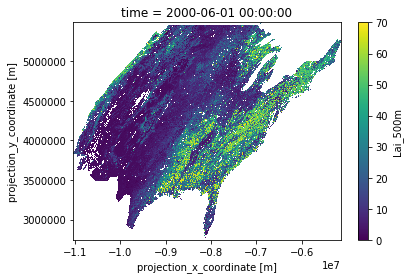

In [4]:
tmp = nc['Lai_500m'].isel(time=0).load().astype('float') # get first lai timestep, convert to float
numpy.place(tmp.data,tmp.data>100.,numpy.nan)

tmp.plot.imshow()

# Processing (example: MOD15A2H)

### 1. Reduce `x` and `y` dimensions to minimum drylands extent and apply drylands mask

We use the aridity index shapefile as the mask that represents drylands ecosystem coverage. Select only the features that represent dryland ecosystem conditions (I did this in ArcMap) and reproject the remaining features to the MODIS Sinusoidal coordinate system (I don't trust ArcMap).

#### Reproject

I used GDAL/OGR command line tool `ogr2ogr` to transform the aridity index shapefile (~drylands mask) from WGS84 to MODIS sinusoidal:

[ogr2ogr](https://www.gdal.org/ogr2ogr.html) use `ogr2ogr` to do the transformation:
```
# proj4 string for MODIS Sinusoidal:        
# +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

ogr2ogr -a_srs "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs " data/ai/ai-drylands-sinu.shp data/ai/ai-drylands.shp
```

Open the reprojected shapefile for later use and print the WKT:

In [5]:
shp = ogr.Open(shapefile)    # open shapefile
lyr = shp.GetLayer()         # get first (and only) layer
srs = lyr.GetSpatialRef()    # get srs
srs.ExportToWkt()            # print the WKT

'PROJCS["Sinusoidal",GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["longitude_of_center",0.0],UNIT["Meter",1.0]]'

#### Rasterize drylands mask to each MODIS product grid

Now that the drylands mask is in the same SRS as our MODIS datasets, we can convert the mask to a grid.

We'll get some spatial reference information from each dataset and use the python binding for the `gdal_rasterize` command-line tool to generate binary drylands masks (one per dataset).       

`gdal.RasterizeLayer()` to make a mask matching  grid in the MOD15A2H dataset and get min extent encompassing the mask.

* get dimensions and min bounding coordinates of xy dimensions in input netCDF [ `xarray` ]
* calculate cell size and define geotransformation
* return the rasterized dryland mask as a grid matching the input netCDF

In [6]:
ncols,nrows = nc.xdim.size,nc.ydim.size    # get number of cols and rows
ymax,ymin = max(nc.ydim),min(nc.ydim)      # get max and min for y
xmax,xmin = max(nc.xdim),min(nc.xdim)      # get max and min for x
yres=(ymax-ymin)/float(nrows)              # get y res
xres=(xmax-xmin)/float(ncols)              # get x res
geotransform=(xmin,xres,0,ymax,0, -yres)   # define geotransformation

dst_ds = gdal.GetDriverByName('MEM').Create('', ncols, nrows, 1 ,gdal.GDT_Byte)   # open raster obj in memory
dst_rb = dst_ds.GetRasterBand(1)
dst_rb.Fill(0)                             # init with zeros
dst_rb.SetNoDataValue(0)                   # set nodata value
dst_ds.SetGeoTransform(geotransform)       # set geotransform

err = gdal.RasterizeLayer(dst_ds, [1], lyr, burn_values=[1])   # rasterize shp. drylands == 1 ; not drylands == 0
dst_ds.FlushCache()

m = dst_ds.GetRasterBand(1).ReadAsArray()  # get mask as a numpy array

Add the mask array to the input dataset as a new variable using the `xarray.DataArray` method:

In [7]:
# add the mask to the input dataset as a new variable called 'drylands'
nc['drylands'] = xarray.DataArray( m , coords = [ nc.ydim , nc.xdim ] , dims = [ 'ydim' , 'xdim' ] )
nc.drylands.attrs = {                           # add some attributes to describe the new mask variable
    'grid_mapping':'crs',                           # "grid_mapping" (CF standard) instruct software how to grid data
    'flag_values':(0,1),                            # "flag_values" sometimes interpretable by software
    'flag_meanings':'non_drylands drylands',        # same is true for "flag_meanings" 
    '_FillValue':0                                  # and most software hide "_FillValues" by default
}
nc

<xarray.Dataset>
Dimensions:     (time: 226, xdim: 12761, ydim: 5932)
Coordinates:
  * time        (time) object 2000-06-01 00:00:00 ... 2018-08-29 00:00:00
  * ydim        (ydim) float64 5.491e+06 5.491e+06 ... 2.744e+06 2.744e+06
  * xdim        (xdim) float64 -1.105e+07 -1.105e+07 ... -5.135e+06 -5.135e+06
Data variables:
    crs         int8 ...
    FparLai_QC  (time, ydim, xdim) int16 dask.array<shape=(226, 5932, 12761), chunksize=(5, 1000, 1000)>
    Lai_500m    (time, ydim, xdim) int16 dask.array<shape=(226, 5932, 12761), chunksize=(5, 1000, 1000)>
    drylands    (ydim, xdim) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    title:        MOD15A2H.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.13
    references:   See README.txt
    history:      See README.txt

Get minimum bounding extent of the mask layer (in grid coordinates) and remove outer columns and rows that are entirely nodata. Then apply the mask:

In [8]:
### get minimum bounding extent of the mask
nzero_ix = numpy.argwhere(m)                    # get index of every non-zero point
tl = nzero_ix.min(axis=0).tolist()              # get min of indices for both dims
br = nzero_ix.max(axis=0).tolist()              # get max of indices for both dims
ext = [v for v in [tl[0],br[0],tl[1],br[1]]]    # _ymax _ymin _xmax _xmin

### print some details about the mask
print("Before trimming: (" + str(nc.xdim.size) + " , " + str(nc.ydim.size) + ")")
print("Minimum drylands bounding extent in grid units:\n\t[ min_row, max_row, min_col, max_col ] \n\t"+str(ext))
nc = nc[ dict(ydim=slice(ext[0],ext[1]), xdim=slice(ext[2],ext[3])) ]
print("After trimming: (" + str(nc.xdim.size) + " , " + str(nc.ydim.size) + ")")
nonzero_ix, tl, br, m = None, None, None, None # discard objects

### mask the Lai_500m variable using the drylands mask
nc['Lai_500m'] = nc['Lai_500m'].where( nc.drylands == 1 , 255 )
nc['Lai_500m']

Before trimming: (12761 , 5932)
Minimum drylands bounding extent in grid units:
	[ min_row, max_row, min_col, max_col ] 
	[92, 5647, 0, 8006]
After trimming: (8006 , 5555)


<xarray.DataArray 'Lai_500m' (time: 226, ydim: 5555, xdim: 8006)>
dask.array<shape=(226, 5555, 8006), dtype=int16, chunksize=(5, 908, 1000)>
Coordinates:
  * time     (time) object 2000-06-01 00:00:00 ... 2018-08-29 00:00:00
  * ydim     (ydim) float64 5.449e+06 5.448e+06 ... 2.876e+06 2.876e+06
  * xdim     (xdim) float64 -1.105e+07 -1.105e+07 ... -7.338e+06 -7.338e+06
Attributes:
    _FillValue:             255
    grid_mapping:           crs
    valid_min:              0
    valid_max:              100
    scale_factor_err:       0.0
    add_offset_err:         0.0
    calibrated_nt:          21
    long_name:              MOD15A2H MODIS/Terra Gridded 500M Leaf Area Index...
    units:                  m^2/m^2
    MOD15A2_FILLVALUE_DOC:  MOD15A2 FILL VALUE LEGEND\n255 = _Fillvalue, assi...
    scale_factor:           0.1
    add_offset:             0.0

-----------
### 2. Remove poor quality observations

#### Prepare quality filtering criteria

The criteria that were used to determine the mask are stored in `qc.json` in the base directory of the repo. *Those listed in the file represent pixels that were retained.*

In [9]:
### open lookup table for mod15a2h and select mod15a2h filtering criteria from qc.json
lookup = pandas.read_csv(datasets['mod15a2h']['lookup'])
criteria = qc[datasets['mod15a2h']['var']]

print("qc.json (base directory) stores criteria that indicate a valid pixel:")
pprint(criteria)

### get quality layer values that represent bad quality from qc.json 
qcv = lookup.loc[(( 
    lookup[ list(criteria.keys())[0] ].isin( list(criteria.values())[0] ) & 
    lookup[ list(criteria.keys())[1] ].isin( list(criteria.values())[1] )
)), "Value"].tolist()

print("\nPixels with these values in the quality layer will be filtered: "+str(qcv))
criteria = None # discard objects

qc.json (base directory) stores criteria that indicate a valid pixel:
{'MODLAND': ['Good quality (main algorithm with or without saturation)'],
 'SCF_QC': ['Main (RT) method used, best result possible (no saturation)',
            'Main (RT) method used with saturation. Good, very usable']}

Pixels with these values in the quality layer will be filtered: [0, 8, 16, 32, 40, 48]


#### Apply mask from `FparLai_QC` to `Lai_500m` using rules specified in `qcv`

We can drop the quality layer from the dataset after the filtering and save some disk space.

In [10]:
nc['Lai_500m'] = nc['Lai_500m'].where( nc['FparLai_QC'].isin(qcv) , 255 ) # apply filter
nc = nc.drop('FparLai_QC')                                                # drop quality layer

#### Checks

We can check that the filtering was done properly by checking a point sample against a time series from the [MODIS/VIIRS Web Service maintained by the ORNL DAAC](https://modis.ornl.gov/data/modis_webservice.html).

We can use the `pyproj` package to convert sample sinusoidal coordinates to geographic coordinates. Then, pass the test points to the web service like so:
```
from pyproj import transform,Proj
from requests import get
from json import loads

# make pyproj objects for wgs84 [epsg code] and modis sinusoidal [proj4]
wgs84 = Proj("+proj=longlat +datum=WGS84 +no_defs")
sinu = Proj('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

# pick x,y pair near grid center because lots of nodata
_gridx,_gridy = int((ext[3]-ext[2])/2) , int((ext[1]-ext[0])/2) # average of dim bounds
_x,_y = nc.xdim.data[_gridx] , nc.ydim.data[_gridy] # get sinu x,y at those positions

print("sinusoidal x,y pair: " + str([_x,_y]))

# transform sample x,y pair(s)
_lng,_lat = transform( sinu , wgs84 , _x , _y )

print("geographic lng,lat pair: " + str([_lng,_lat]))

# build the request string to submit to the MODIS/VIIRS Web Service [REST-based API]
response = get(
    str(
        'https://modis.ornl.gov/rst/api/v1/' + 'MOD15A2H/subset?' + # api + <product>/subet?
        'latitude=' + str(_lat) + '&longitude=' + str(_lng) + # <latitude> <longitude
        '&band=Lai_500m' + # "&band=<band>"
        '&startDate=' + 'A2000153' + '&endDate=' + 'A2000213' + # Jun,Jul 2000; <startdoy> <enddoy>
        '&kmAboveBelow=0&kmLeftRight=0'
     ,
    headers = {'Accept': 'application/json'}
)

sample = loads(response.text)
```

The web service is a really great tool for access MODIS and VIIRS data programmatically. A ton of useful metadata is stored in the response (json -> python dictionary), but it's too big to pretty-print inside the jupyter notebook. Here's everything but the subset element (data are printed though) if you'd like to explore later:
```
subset = [s['data'][0] for s in sample['subset']]
print("Subset metadata: \n\n" + "\n".join(["\t"+k+"\t"+str(v) for k,v in sample.items() if k != 'subset' ]))
subset = None # discard objects
```

The subset we requested from ORNL DAAC is the first two months of our time series, so we can extract the same values from our time series using the grid positions we calculated above and the first ~8 values of our time series.
```
check = nc['Lai_500m'][0:len(subset),_gridy,_gridx].load()
print("Our time series: " + str( check ))
print("ORNL DAAC time series: " + str( subset ))
```

----------
### 4. Save time series

Now that all of the filtering is complete we just need to save the file and calculate statistics. The computer hasn't actually done any of the work yet. `xarray` uses `dask` to queue a list of operations to perform on the data and then executes them chunk-wise as it writes to the output file.

Before calculating statistics, save the time series:

In [11]:
from dask.diagnostics import ProgressBar # load dask's progress bar

output = "outputs/mod15a2h_processed.nc"                                 # output netcdf
timeseries = nc.to_netcdf(output, unlimited_dims="time" , compute=False) # initialize output job

with ProgressBar():       # do queued calculations and save
    timeseries.compute()
timeseries = None         # discard objects

[########################################] | 100% Completed | 19min 24.0s


or save one file per year:
 ```
slices = {str(y): nc.sel(time=slice(str(y),str(y))) for y in list(set(nc.time.dt.year.data)) }
for year,dataset in slices.items(): 
    j = dataset.to_netcdf(p+"mod15a2h_"+year+"_timeseries.nc", unlimited_dims=("time"), compute=False)
    with ProgressBar(): 
        j.compute()
```

----------------
### 5. Calculate stats

Now calculate mean and standard deviation by month. Purge the opened netCDF and open the one that was just saved, applying the mask and scale factor (warning: changes data type to float):

In [12]:
nc = None                                   # purge opened netcdf

d = datasets['mod15a2h']                    # get the dictionary for MOD15A2H
d.update({'dataset':'mod15a2h'})            # add dataset string
output = "outputs/mod15a2h_test_stats.nc"   # output path

_dataset = d['dataset'] #'{dataset}'        # This is the info that comes from datasets.json -->
_file = d['output'] #'{output}'             #      {bracketed} comments are for reference to the       
_datavar = d['datavar'] #'{datavar}'        #      script generator at the bottom of the notebook
_long_name = d['long_name'] #'{valid_max}'  #
_valid_min = d['valid_min'] #'{valid_min}'  #
_valid_max = d['valid_max'] #'{valid_max}'  #

_mean = _datavar+"_mean"                    # for renaming "Lai_500m" to "Lai_500m_mean"
_variance = _datavar+"_variance"            # ... variance
_stdev = _datavar+"_stdev"                  # ... stdev

**Note:** Calculated standard deviation as ...
* the **square root of the variance for each pixel** for gridded outputs, and 
* the **square root of the mean of the variance across all pixels** for series outputs
because calculating mean and standard deviation over a 3-dim stack (x,y,time; to get single monthly value for series output) was too computationally expensive. 

Use `xarray.groupby()` function to calculate means and standard deviations by month:

In [13]:
numpy.seterr(divide='ignore', invalid='ignore')           # tell numpy to ignore nan warnings

### open the dataset; 'mask_and_scale'=True this time (sets fill value to nan, as numpy has no nan for ints)
nc = xarray.open_dataset( _file, mask_and_scale = True, chunks = { 'time':5, 'ydim': 1000, 'xdim': 1000 } )

### make some modifications 
drylands = nc['drylands']                                 # save the drylands layer for later, 
nc = nc.drop('drylands')                                  #     and remove it so not duplicated
nc = nc.sel(time=slice("2000-01-01","2003-01-01"))        # select first two years for testing
nc[_datavar].attrs.update( dict(                          # replace valid range attributes for "Lai_500m"
    valid_min=_valid_min , valid_max=_valid_max ) )       #     because values are scaled now 

### store dates and statistics for each month in nested dictionaries
data = dict( dates=[] ,                                   # pandas datetimes (1st of each month)
             grid=dict( mean=[],variance=[],stdev=[] ) ,  # drylands grid mean, variance, and stdev
             series=dict( mean=[],stdev=[] ) )            # time series mean and stdev 

### loop over years, then months (nested) and append outputs to 'data' dictionary
for year,dataset in nc.groupby('time.year', squeeze=False):                    # loop over years
    for month,subdataset in dataset.groupby('time.month', squeeze=False):      # loop over months

        data['dates'].append(pandas.to_datetime(str(year)+"-0"+str(month)+"-"+"01")) # append date

        ### grid statistics
        _m = subdataset[_datavar].mean('time', keep_attrs = True, skipna=True) # calc mean by pixel
        data['grid']['mean'].append( _m )                                      # append mean
        
        _v = subdataset[_datavar].var('time', keep_attrs = True, skipna=True)  # calc variance by pixel
        data['grid']['variance'].append( _v )                                  # append variance
        data['grid']['stdev'].append( xarray.ufuncs.sqrt(_v) )                 # append stdev
 
        ### series statistics
        data['series']['mean'].append( _m.mean(['xdim','ydim'],keep_attrs = True) ) # append series mean
        data['series']['stdev'].append( xarray.ufuncs.sqrt(_v.mean(['ydim','xdim'],skipna = True)) ) # append series stdev

**Organize results:**      
Concatenate the outputs for each type and variable, then merge into two datasets. Rename the record dimension to `time` and add the CRS and Drylands mask variables to the gridded output dataset:

In [14]:
### concatenate monthly grid outputs
grid = xarray.merge([ 
    xarray.concat(data['grid']['mean'], dim=data['dates']).rename(_mean),
    xarray.concat(data['grid']['variance'], dim=data['dates']).rename(_variance),
    xarray.concat(data['grid']['stdev'], dim=data['dates']).rename(_stdev)
])
grid = grid.rename({'concat_dim':'time'})       # rename time dimension
grid['crs'] = nc.crs                            # add crs variable
grid['drylands'] = drylands                     # add drylands mask back to dataset

### concatenate monthly series outputs
series = xarray.merge([ 
    xarray.concat(data['series']['mean'], dim=data['dates']).rename(_mean),
    xarray.concat(data['series']['stdev'], dim=data['dates']).rename(_stdev)
])
series = series.rename(dict(concat_dim='time')) # rename time dimension

**Save the outputs to one netCDF file:**

In [15]:
xarray.Dataset().to_netcdf(output, unlimited_dims=("time"), compute=True) # make container dataset

### make write job for each (grid,series) and write to their own groups in the container dataset.
writeg = grid.to_netcdf(output, mode="a", group="/grid/", unlimited_dims=("time"), compute=False)
writes = series.to_netcdf(output, mode="a", group="/series/", unlimited_dims=("time"), compute=False)

with ProgressBar(): 
    for j in [writeg,writes]:
        j.compute()

[########################################] | 100% Completed |  1min 57.2s
[########################################] | 100% Completed |  1min  3.8s


--------------------------
# Write processing scripts


The two code blocks below write python scripts for each dataset in `datasets.json`. Run from the base directory of the repo or minor adjustments may be required.

```
<dataset> ==  [ 'mod15a2h' 'myd15a2h' 'mod11a1d' 'mod11a1n' 'myd11a1d' 'myd11a1n' ]`
<script> ==  [ 'timeseries' 'stats' ] 
```

* **if run in a virtualenv:**

```
$ python proc/<dataset>_<script>.py
```

* **else:**

```
$ chmod +x proc/<dataset>_<script>.py
$ proc/<dataset>_<script>.py
```

### Prepare datasets
Trim datasets to processing extent, apply drylands mask, filter out poor quality data    

In [16]:
datasets = json.load( open( "datasets.json" , "r" ) )
python_path = "/usr/bin/python"


for dataset,details in datasets.items():
    details['dataset'] = dataset
    details['pypath'] = python_path
    with open("proc/"+dataset+"_timeseries.py","w") as f:
        f.write(
"""#!{pypath}

import os
import xarray
from osgeo import gdal, ogr, osr
from dask.diagnostics import ProgressBar
import numpy
import pandas
import json
from collections import OrderedDict

if not os.path.exists('outputs'): os.makedirs('outputs')      # make outputs dir if none exists

_dataset = '{dataset}'
_f = '{file}'
_output = '{output}'
_lookup = '{lookup}'
_var = '{var}'
_datavar = '{datavar}'
_qcvar = '{qcvar}'
_fillvalue = {fillvalue}
_discard_vars = {discard_vars}

shapefile = "data/ai/ai-drylands-sinu.shp"    # reprojected aridity index shapefile
qc = json.load( open( "qc.json" , "r" ) )

nc = xarray.open_dataset(   # open the netCDF dataset in parallel i/o mode
    _f , 
    mask_and_scale = False ,                                   # no, changes to floats
    drop_variables = _discard_vars,                            # discard these
    chunks =  dict(time=5, ydim= 1000, xdim= 1000)             # ~5m
)

print("---\tMaking drylands mask . . . ")

shp = ogr.Open(shapefile)                     # open shapefile
lyr = shp.GetLayer()                          # get first (and only) layer
srs = lyr.GetSpatialRef()                     # get srs

ncols,nrows = nc.xdim.size,nc.ydim.size    # get number of cols and rows
ymax,ymin = max(nc.ydim),min(nc.ydim)      # get max and min for y
xmax,xmin = max(nc.xdim),min(nc.xdim)      # get max and min for x
yres=(ymax-ymin)/float(nrows)              # get y res
xres=(xmax-xmin)/float(ncols)              # get x res
geotransform=(xmin,xres,0,ymax,0, -yres)   # define geotransformation

dst_ds = gdal.GetDriverByName('MEM').Create('', ncols, nrows, 1 ,gdal.GDT_Byte)   # open raster obj in memory
dst_rb = dst_ds.GetRasterBand(1)
dst_rb.Fill(0)                          # init with zeros
dst_rb.SetNoDataValue(0)                # set nodata value
dst_ds.SetGeoTransform(geotransform)    # set geotransform

err = gdal.RasterizeLayer(dst_ds, [1], lyr, burn_values=[1])   # rasterize shp. drylands == 1 ; not drylands == 0
dst_ds.FlushCache()

m = dst_ds.GetRasterBand(1).ReadAsArray()

nzero_ix = numpy.argwhere(m)                    # get index of every non-zero point
tl = nzero_ix.min(axis=0).tolist()              # get min of indices for both dims
br = nzero_ix.max(axis=0).tolist()              # get max of indices for both dims
ext = [v for v in [tl[0],br[0],tl[1],br[1]]]    # _ymax _ymin _xmax _xmin

print("---\tMasking dataset . . . ")

# add the mask to the input dataset as a new variable called 'drylands'
nc['drylands'] = xarray.DataArray( m , coords = [ nc.ydim , nc.xdim ] , dims = [ 'ydim' , 'xdim' ] )
nc.drylands.attrs = dict(                         # add some attributes to describe the new mask variable
    grid_mapping='crs',                           # "grid_mapping" (CF standard) instruct software how to grid data
    flag_values=(0,1),                            # "flag_values" sometimes interpretable by software
    flag_meanings='non_drylands drylands',        # same is true for "flag_meanings" 
    _FillValue=0                                  # and most software hide "_FillValues" by default
)
nc = nc[ dict(ydim=slice(ext[0],ext[1]), xdim=slice(ext[2],ext[3])) ] # trim dataset to mask extent
nc[_datavar] = nc[_datavar].where( nc.drylands == 1 , _fillvalue ) # apply mask

print("---\tQuality filtering . . . ")

lookup = pandas.read_csv(_lookup)
criteria = qc[_var]
qcv = lookup.loc[(
    ( lookup[ list(criteria.keys())[0] ].isin( list(criteria.values())[0] ) & 
      lookup[ list(criteria.keys())[1] ].isin( list(criteria.values())[1] ))
), "Value"].tolist()
nc[_datavar] = nc[_datavar].where( nc[_qcvar].isin(qcv) , _fillvalue ) # apply filter
nc = nc.drop(_qcvar)

print("---\tWriting output time series:  . . . ")

from dask.diagnostics import ProgressBar # load dask's progress bar

# initialize output job
timeseries = nc.to_netcdf( _output , unlimited_dims="time" , compute=False )

# do queued calculations and save
with ProgressBar(): 
    timeseries.compute()

""".format(**details))

### Calculate stats
Calculate mean and standard deviation over time and space

In [17]:
datasets = json.load( open( "datasets.json" , "r" ) )
python_path = "/usr/bin/python"

for dataset,details in datasets.items():
    details['pypath'] = python_path
    details['dataset'] = dataset
    with open("proc/"+dataset+"_stats.py","w") as f:
        f.write(
"""#!{pypath}

import os,json,math                        # general env use and reading json configs
import xarray,pandas,numpy                 # <-- these do 99.9% of processing
from osgeo import gdal, ogr, osr           # to grid shapefile mask and transform netcdf crs for plots

from collections import OrderedDict        # text-escaped dictionarys in output scripts
from dask.diagnostics import ProgressBar   # progress bar for long saves

numpy.seterr(divide='ignore', invalid='ignore')

_dataset = '{dataset}'
_file = '{output}'
_datavar = '{datavar}'
_valid_min = '{valid_min}'
_valid_max = '{valid_max}'

_mean = _datavar+"_mean"
_variance = _datavar+"_variance"
_stdev = _datavar+"_stdev"

nc = xarray.open_dataset(
    _file, 
    mask_and_scale = True,    
    chunks = dict( time=5, ydim= 1000, xdim= 1000 ) 
)
drylands = nc['drylands']
nc = nc.drop('drylands')

################################################## TESTING
#nc = nc.sel(time=slice("2000-01-01","2003-01-01"))
################################################## TESTING

nc[_datavar].attrs.update(dict(valid_min=_valid_min,valid_max=_valid_max))

data = dict( dates=[] , grid=dict( mean=[],variance=[],stdev=[] ) , series=dict( mean=[],stdev=[] ) )
for year,dataset in nc.groupby('time.year', squeeze=False):
    for month,subdataset in dataset.groupby('time.month', squeeze=False):

        data['dates'].append(pandas.to_datetime(str(year)+"-0"+str(month)+"-"+"01")) 

        _m = subdataset[_datavar].mean('time', keep_attrs = True, skipna=True)
        data['grid']['mean'].append( _m )
        _v = subdataset[_datavar].var('time', keep_attrs = True, skipna=True)
        data['grid']['variance'].append( _v )
        data['grid']['stdev'].append( xarray.ufuncs.sqrt(_v) )

        data['series']['mean'].append( _m.mean(['xdim','ydim'],keep_attrs = True) )
        data['series']['stdev'].append( xarray.ufuncs.sqrt(_v.mean(['ydim','xdim'],skipna = True)) )

grid = xarray.merge([
    xarray.concat(data['grid']['mean'], dim=data['dates']).rename(_mean),
    xarray.concat(data['grid']['variance'], dim=data['dates']).rename(_variance),
    xarray.concat(data['grid']['stdev'], dim=data['dates']).rename(_stdev)
])
grid = grid.rename(dict(concat_dim='time'))
grid['crs'] = nc.crs 
grid['drylands'] = drylands

series = xarray.merge([
    xarray.concat(data['series']['mean'], dim=data['dates']).rename(_mean),
    xarray.concat(data['series']['stdev'], dim=data['dates']).rename(_stdev)
])
series = series.rename(dict(concat_dim='time'))#,xdim='x',ydim='y'))

outf = "outputs/"+_dataset+"_stats.nc"
xarray.Dataset().to_netcdf(outf, unlimited_dims=("time"), compute=True)
writeg = grid.to_netcdf(outf, mode="a", group="/grid/", unlimited_dims=("time"), compute=False)
writes = series.to_netcdf(outf, mode="a", group="/series/", unlimited_dims=("time"), compute=False)

with ProgressBar(): 
    for j in [writer1,writer2,writer3]:
        j.compute()

""".format(**details))